# Final Projects 90-803: MLFP Spring 2023
## Team 9
### Question 3: Can we classify the severity of vehicle damage in accidents based on factors like speed limits, location, and lighting conditions? If so, what environmental factors have the most contribution to the result?
Classification - target variable: DAMAGE_IND, where 0 – None, 1 – Minor (Drivable), 2 - Functional (may be undrivable), 3 – Disabling (severe )

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample


import warnings
warnings.filterwarnings('ignore')

In [26]:
df3=pd.read_csv("Q3.csv")
df3.head()

,Unnamed: 0,DAMAGE_IND,URBAN,AGGRESSIVE_DRIVING,DISTRACTED,SPEED_LIMIT,ILLUMINATION,CURVED_ROAD
0,0,3.0,0,1,0,1.575385,1,0
1,1,3.0,0,1,0,1.575385,1,0
2,2,3.0,0,1,0,1.575385,1,0
3,3,3.0,1,1,1,0.709924,1,0
4,4,3.0,1,1,1,0.709924,1,0


In [27]:
df3.drop('Unnamed: 0', axis=1, inplace=True) # drop useless column

In [4]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834863 entries, 0 to 3834862
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   DAMAGE_IND          float64
 1   URBAN               int64  
 2   AGGRESSIVE_DRIVING  int64  
 3   DISTRACTED          int64  
 4   SPEED_LIMIT         float64
 5   ILLUMINATION        int64  
 6   CURVED_ROAD         int64  
dtypes: float64(2), int64(5)
memory usage: 204.8 MB


In [5]:
df3['DAMAGE_IND'] = df3['DAMAGE_IND'].astype('category') # change the data type into category

In [6]:
df3.isnull().sum()

DAMAGE_IND            0
URBAN                 0
AGGRESSIVE_DRIVING    0
DISTRACTED            0
SPEED_LIMIT           0
ILLUMINATION          0
CURVED_ROAD           0
dtype: int64

Correct data type and no missing values

### 1. EDA
#### 1.1  Plot a correlation heatmap

<AxesSubplot:>

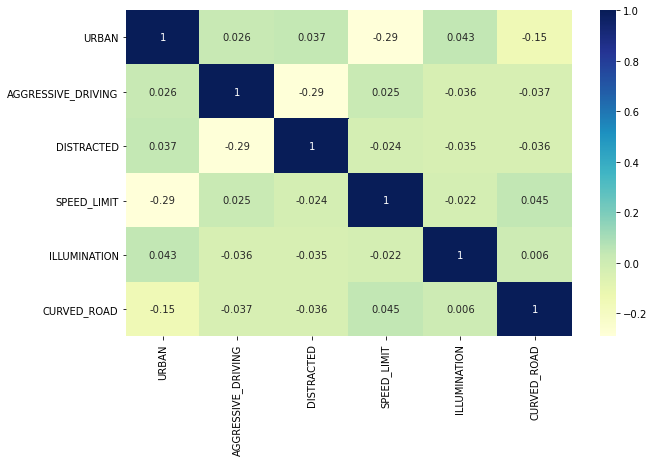

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(df3.corr(),cmap="YlGnBu", annot=True)

The correlation between the variables is low, with most correlation coefficients less than 0.1.

#### 1.2 Count of DAMAGE Indicator

Text(0.5, 1.0, 'Countpolt on Damage Indicator')

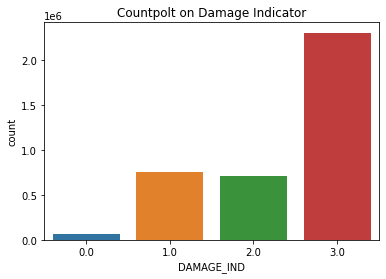

In [8]:
sns.countplot(x='DAMAGE_IND',data=df3)
plt.title('Countpolt on Damage Indicator')

We can see that there is an imbalance between the classes, where class 3 - Disabling (severe) Damage has the most data, while class 0 - None Damage has the least data.

### 2. Feature Engineering

In [28]:
data = df3.copy()
class_counts = data['DAMAGE_IND'].value_counts()
class_counts

3.0    2300188
1.0     755286
2.0     711361
0.0      68028
Name: DAMAGE_IND, dtype: int64

Since there is an imbalance between the categories and the data sample is sufficient, we choose to randomly select 10,000 data from each class

In [29]:
num_samples_per_class = 10000
classes = {label: data[data.DAMAGE_IND == label] for label in class_counts.index}

# downsample the dataset
downsampled_classes = {
    label: resample(class_df,
                    replace=True,  # Set to True for upsampling
                    n_samples=num_samples_per_class,
                    random_state=42)
    for label, class_df in classes.items()
}

downsampled_data = pd.concat(downsampled_classes.values())

df3 = downsampled_data.sample(frac=1, random_state=42).reset_index(drop=True)

### 3. Training

Split the dataset into X_train, X_test, y_train and y_test. Use a 80-20 ratio for the split and a random_state=42.

In [11]:
# split data into X and y
X = df3.loc[:, df3.columns != "DAMAGE_IND"]
y = df3["DAMAGE_IND"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test

32823    3.0
16298    0.0
28505    3.0
6689     3.0
26893    3.0
        ... 
13618    0.0
35165    2.0
16359    3.0
3842     2.0
37682    3.0
Name: DAMAGE_IND, Length: 8000, dtype: category
Categories (4, float64): [0.0, 1.0, 2.0, 3.0]

#### 3.1 Logistic Regression

In [12]:
param_grid = {'C': [0.1,0.05,0.06,0.07,0.08,0.09,0.11,0.12]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
lr_grid.fit(X_train, y_train)
print("Logistic Regression - Best parameters:", lr_grid.best_params_)

Logistic Regression - Best parameters: {'C': 0.05}


In [13]:
lr = LogisticRegression(C=0.05, max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy (LR with Grid Search): {:.2f}%".format(accuracy_lr * 100))
print(classification_report(y_test, lr_grid.predict(X_test)))

Accuracy (LR with Grid Search): 32.81%
              precision    recall  f1-score   support

         0.0       0.38      0.44      0.41      1982
         1.0       0.32      0.13      0.18      1967
         2.0       0.28      0.44      0.34      2021
         3.0       0.35      0.30      0.32      2030

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.31      8000
weighted avg       0.33      0.33      0.31      8000



The model's performance seems to be relatively low, with an overall accuracy of 32.81%. Considering there are four classes (0, 1, 2, and 3), a random guess would result in a 25% accuracy, so this model does not perform significantly better than random chance.

In [14]:
# Get the feature importances
importances = np.abs(lr.coef_[0])

# Print the feature importances
print('Feature Importances:')
for feature, importance in zip(X.columns, importances):
    print(f'{feature}: {importance:.4f}')

Feature Importances:
URBAN: 0.0193
AGGRESSIVE_DRIVING: 0.6097
DISTRACTED: 0.2773
SPEED_LIMIT: 0.2232
ILLUMINATION: 0.0430
CURVED_ROAD: 0.1282


In this model, URBAN and ILLUMINATION have a very low importance. AGGRESSIVE_DRIVING is the most important feature.

#### 3.2 Random Forest

In [15]:
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
rf_grid.fit(X_train, y_train)
print("Random Forest - Best parameters:", rf_grid.best_params_)

Random Forest - Best parameters: {'max_depth': 10, 'n_estimators': 200}


In [30]:
# Define the random forest classifier, and use best grid search parameters
rf = RandomForestClassifier(max_depth = 10, n_estimators= 200)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
print("Accuracy (RF with Grid Search): {:.2f}%".format(accuracy_rf * 100))
print(classification_report(y_test, y_pred))

Accuracy (RF with Grid Search): 32.71%
              precision    recall  f1-score   support

         0.0       0.41      0.41      0.41      1982
         1.0       0.28      0.26      0.27      1967
         2.0       0.28      0.33      0.30      2021
         3.0       0.34      0.30      0.32      2030

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



In [17]:
# Get feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

print("Feature importances:")
for i in range(X_train.shape[1]):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

Feature importances:
1. SPEED_LIMIT: 0.4087
2. AGGRESSIVE_DRIVING: 0.2220
3. ILLUMINATION: 0.1834
4. DISTRACTED: 0.0668
5. URBAN: 0.0607
6. CURVED_ROAD: 0.0584


In the Random Forest model, URBAN, CURVED_ROAD and ILLUMINATION have a very low importance. SPEED_LIMIT is the most important feature.

#### 3.3 Gaussian Naive Bayes

In [18]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train, y_train)
y_pred_gnb = gnb_classifier.predict(X_test)

# Calculate the accuracy
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print("Accuracy (Gaussian Naive Bayes): {:.2f}%".format(accuracy_gnb * 100))

# Print the classification report
print("\nClassification Report (Gaussian Naive Bayes):")
print(classification_report(y_test, y_pred_gnb))

# Print the confusion matrix
print("\nConfusion Matrix (Gaussian Naive Bayes):")
print(confusion_matrix(y_test, y_pred_gnb))

Accuracy (Gaussian Naive Bayes): 32.35%

Classification Report (Gaussian Naive Bayes):
              precision    recall  f1-score   support

         0.0       0.39      0.38      0.39      1982
         1.0       0.33      0.17      0.22      1967
         2.0       0.28      0.51      0.36      2021
         3.0       0.35      0.23      0.28      2030

    accuracy                           0.32      8000
   macro avg       0.34      0.32      0.31      8000
weighted avg       0.34      0.32      0.31      8000


Confusion Matrix (Gaussian Naive Bayes):
[[ 759  234  735  254]
 [ 425  336  908  298]
 [ 403  262 1025  331]
 [ 341  200 1021  468]]


The Gaussian Naive Bayes model's performance is also relatively low, with an overall accuracy of 32.35%. All classes have low f1-scores, indicating that the model has difficulty accurately classifying instances of each class while minimizing false positives and false negatives.

#### 3.4 SVM

In [19]:
param_grid = {'C': [0.1,1], 'kernel': [ 'rbf']}
# Define SVM model and cross-validation
svm_grid = GridSearchCV(SVC(), param_grid, cv=2)
svm_grid.fit(X_train, y_train)
print("SVM - Best parameters:", svm_grid.best_params_)
print(classification_report(y_test, svm_grid.predict(X_test)))

SVM - Best parameters: {'C': 1, 'kernel': 'rbf'}
              precision    recall  f1-score   support

         0.0       0.40      0.43      0.41      1982
         1.0       0.29      0.27      0.28      1967
         2.0       0.28      0.28      0.28      2021
         3.0       0.35      0.34      0.34      2030

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.33      8000
weighted avg       0.33      0.33      0.33      8000



The SVM model's performance is not satisfactory and is similar to the previous models

In [20]:
y_pred_svm = svm_grid.predict(X_test)

### 4. Visualization of Model Performance

In [23]:
# Collect the evaluation metrics for each classifier
metrics = {
    'SVM': {
        'accuracy': accuracy_score(y_test, y_pred_svm),
        'precision': precision_score(y_test, y_pred_svm, average='weighted'),
        'recall': recall_score(y_test, y_pred_svm, average='weighted'),
        'f1': f1_score(y_test, y_pred_svm, average='weighted'),
    },
    'GNB': {
        'accuracy': accuracy_score(y_test, y_pred_gnb),
        'precision': precision_score(y_test, y_pred_gnb, average='weighted'),
        'recall': recall_score(y_test, y_pred_gnb, average='weighted'),
        'f1': f1_score(y_test, y_pred_gnb, average='weighted'),
    },
    'RF': {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
    },
    'LR': {
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'precision': precision_score(y_test, y_pred_lr, average='weighted'),
        'recall': recall_score(y_test, y_pred_lr, average='weighted'),
        'f1': f1_score(y_test, y_pred_lr, average='weighted'),
    },
}

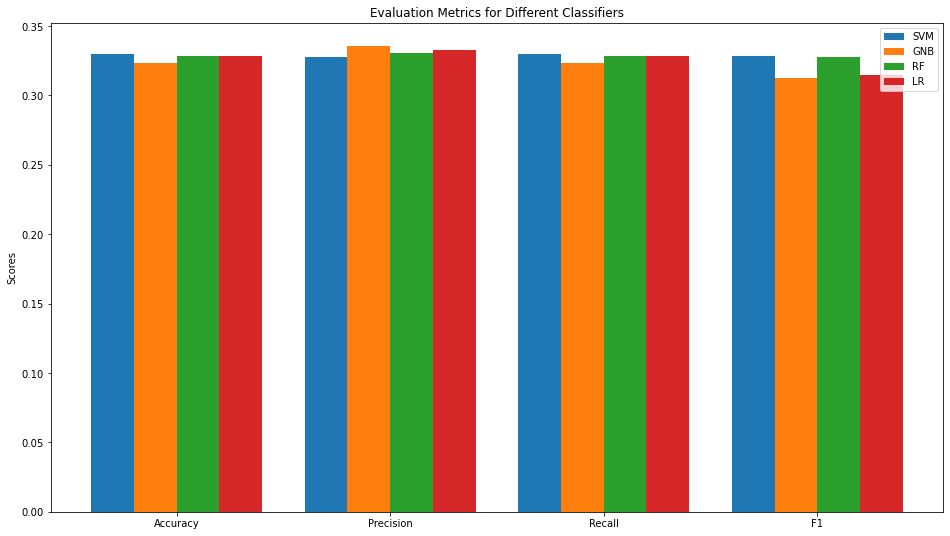

In [24]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
classifiers = ['SVM', 'GNB', 'RF', 'LR']

# Generate data array, rows correspond to labels, columns correspond to classifiers
data = np.array([
    [metrics[classifier]['accuracy'] for classifier in classifiers],
    [metrics[classifier]['precision'] for classifier in classifiers],
    [metrics[classifier]['recall'] for classifier in classifiers],
    [metrics[classifier]['f1'] for classifier in classifiers],
])

x = np.arange(len(labels))
width = 0.2  

# For each classifier, plot the bar chart
fig, ax = plt.subplots(figsize = (16,9)) 
for i, classifier in enumerate(classifiers):
    ax.bar(x + i * width, data[:, i], width, label=classifier)

# Add labels
ax.set_ylabel('Scores')
ax.set_title('Evaluation Metrics for Different Classifiers')
ax.set_xticks(x + width * (len(classifiers) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

### Conclusions and Discussions

All models have relatively low accuracy (32-33%), which is not significantly better than random chance for a four-class problem. It is challenging to classify the severity of vehicle damage in crashes based on factors like speed limits, location, and lighting conditions. This may be because the features we choose are not significant enough. Additionally, the feature importances are very different between different models, for example, in Logistic Regression model, AGGRESSIVE_DRIVING is the most important feature, while in Random Forest model, SPEED_LIMIT is the most important feature.
As a result, we cannotidentify which environmental factors have the most significant contribution to the result using the current 4 models.

### Future Work

For future work, we may try to collect new features which can better capture the infomation in the data. Moreover, we can also try to used larger datasets and other deep learning algorithms to improve the model performances.

### References

* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
* Answers to Lab 5
* Answers to Lab 6